In [2]:
import facet_ml
from facet_ml.classification.model_using import ModelApplication
from facet_ml.classification.model_training import load_feature_config
from facet_ml.static.path import STATIC_MODELS
from sklearn import metrics
import glob
import pandas as pd
import numpy as np
import pickle
import os
import shap
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Arial"

In [3]:
# Load Data from training
training_folder = os.path.join("..","..","ProcessedData","Training_Data_20231106")

csv_list = glob.glob(os.path.join(training_folder,"*"))
df_list = [pd.read_csv(csv,index_col=0) for csv in csv_list]

# Process data
df_total = pd.concat(df_list)
df_total.reset_index(drop=True)
df_total.replace([np.inf, -np.inf], np.nan, inplace=True)
df_total.dropna(axis=0,inplace=True)
df_total.drop(labels=["label","Filename","Region"],axis=1,inplace=True)

# Get and use features
features_oi = load_feature_config("default_features-agnostic")
X = df_total[features_oi]
y = df_total.Labels

In [4]:
# Load models
def load_model(pickle_path:str):
    with open(pickle_path,"rb") as f:
        model = pickle.load(f)

    return model

C_v_MC = load_model(STATIC_MODELS["crystal_multicrystal"])
Crys_v_Nocrys = load_model(STATIC_MODELS["crystalline_noncrystalline"])
total = load_model(STATIC_MODELS["crystal_multicrystal_incomplete"])

Trying to unpickle estimator DecisionTreeClassifier from version 1.2.1 when using version 1.2.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
Trying to unpickle estimator RandomForestClassifier from version 1.2.1 when using version 1.2.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations


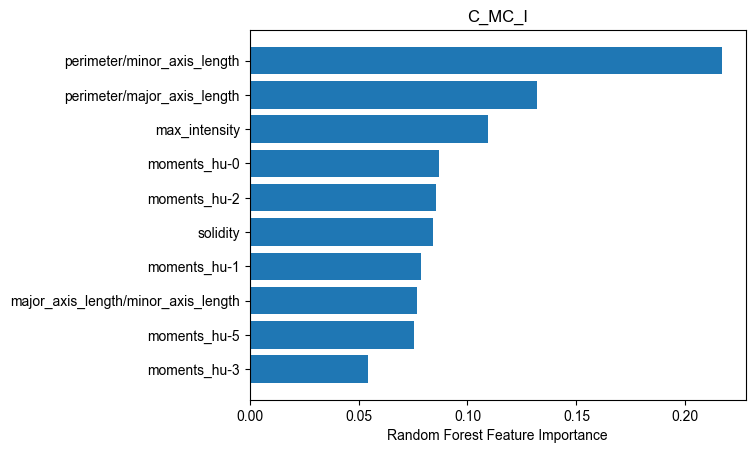

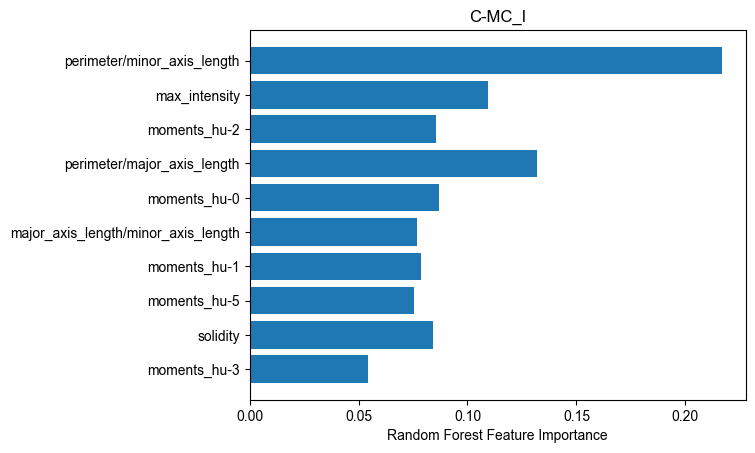

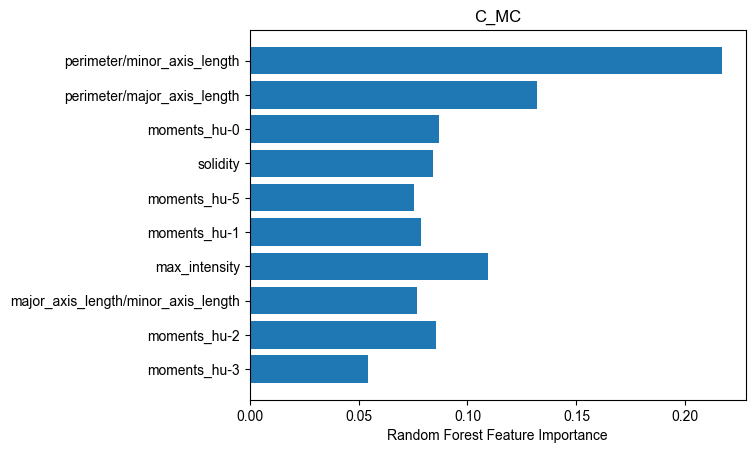

<Figure size 640x480 with 0 Axes>

In [5]:
def feature_importance_model(model_run,title):
    sorted_idx = model_run["model"].feature_importances_.argsort()
    plt.barh(X.columns[sorted_idx], total["model"].feature_importances_[sorted_idx])
    plt.xlabel("Random Forest Feature Importance")
    plt.title(title)
    plt.show()
    plt.savefig(f"S1_impurity_{title}.png")

feature_importance_model(total,"C_MC_I")
feature_importance_model(Crys_v_Nocrys,"C-MC_I")
feature_importance_model(C_v_MC,"C_MC")


In [13]:
def shapley_model_review(model_run,name_mod=""):
    # Combine test and train for a single X
    X = pd.concat([model_run["X_train"],model_run["X_test"]])
    y = pd.concat([model_run["y_train"],model_run["y_test"]])

    explainer = shap.Explainer(total["model"],X)
    shap_values = explainer(X)

    # Get classes
    classes = model_run["model"].classes_

    # Generate violin plots
    for ii, class_oi in enumerate(classes):
        plt.clf()
        shap.plots.violin(shap_values[:,:,ii],show=False,plot_type="layered_violin") # Crystal
        fig = plt.gcf()
        plt.tight_layout()
        fig.suptitle(f"{class_oi} Violin Plot")
        fig.savefig(f"S1_Shapley_{class_oi}_{name_mod}.png",)
        #plt.show()
        #plt.savefig(f"S1_Shapley_{class_oi}.png")
    
    return explainer,shap_values
    

 97%|=================== | 3965/4089 [00:22<00:00]       

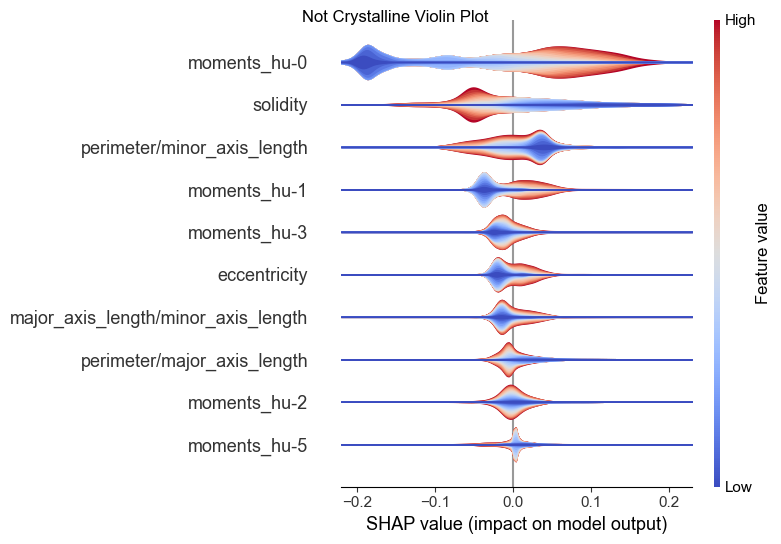

In [14]:

shap_dict = {}
for model_run,name_mod in [
    (total,"C_MC_I"),
    (C_v_MC,"C_MC"),
    (Crys_v_Nocrys,"C-MC_I")]:
    explainer,shap_values = shapley_model_review(model_run,name_mod)
    shap_dict[name_mod] = (explainer,shap_values)


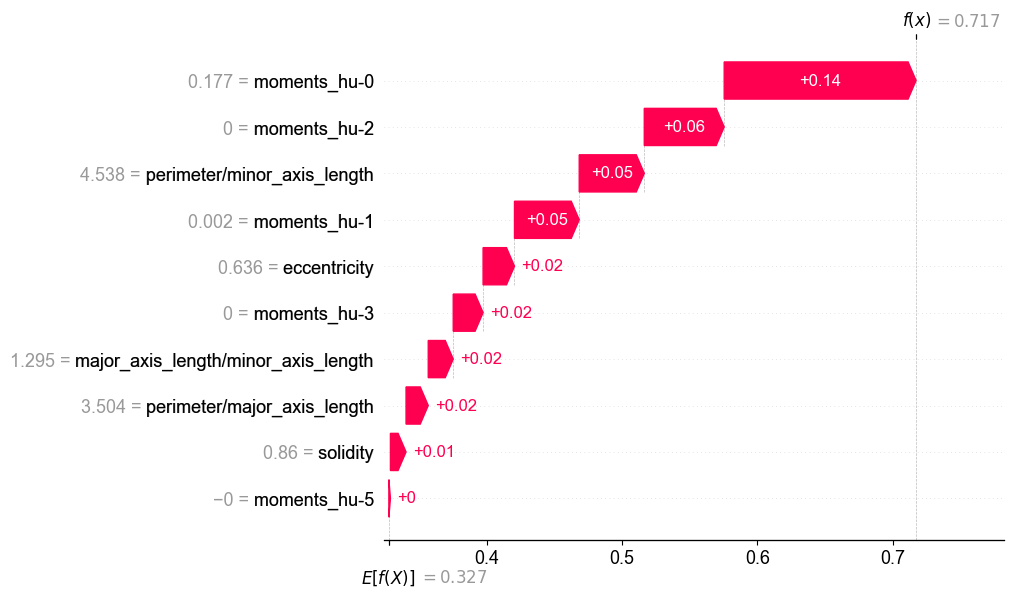

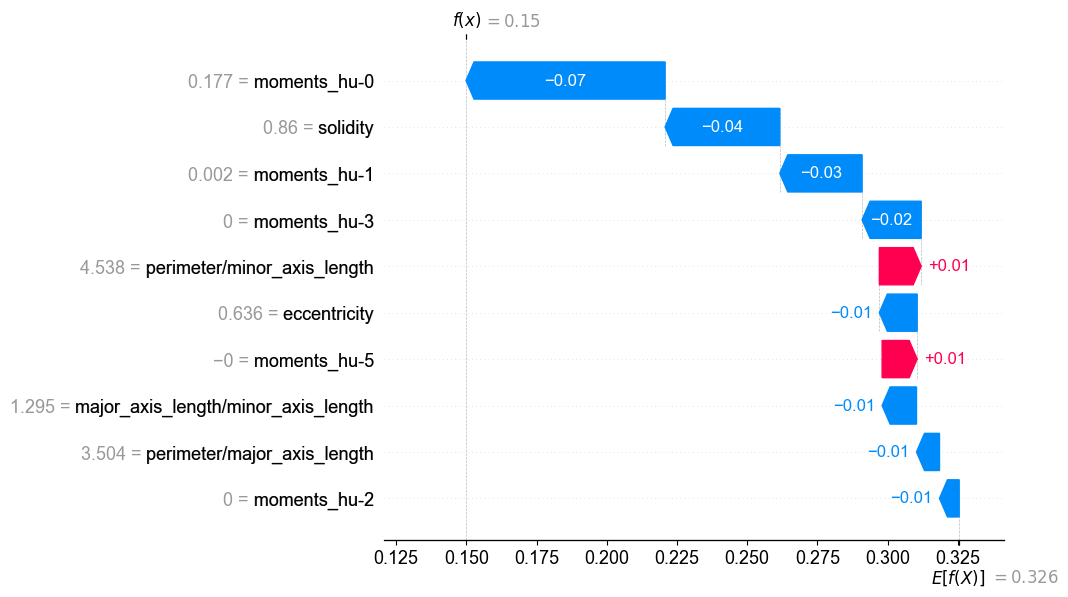

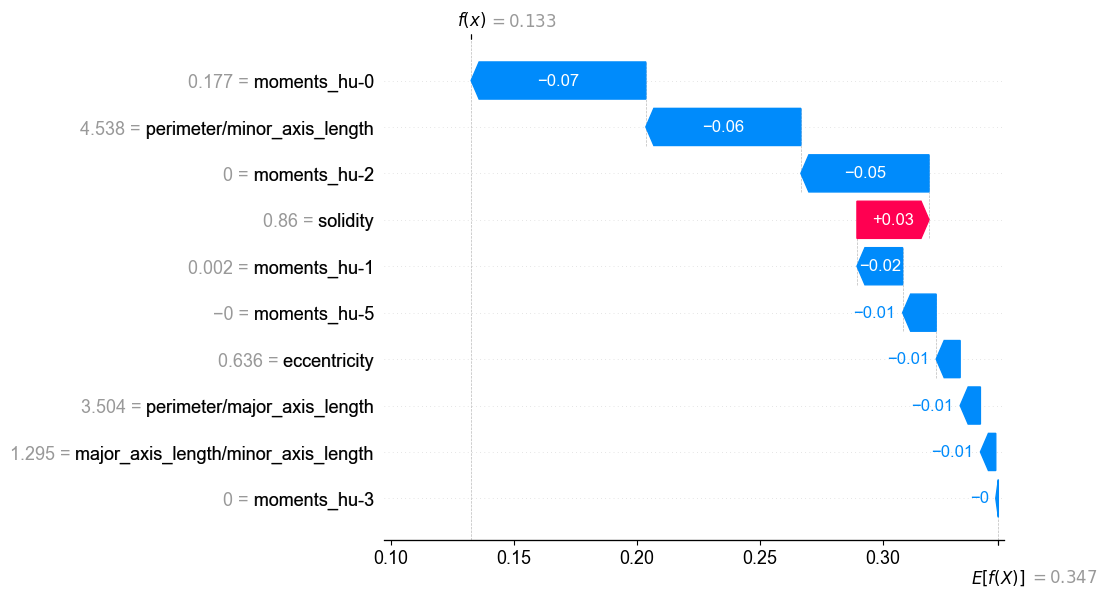

In [8]:
# the waterfall_plot shows how we get from shap_values.base_values to model.predict(X)[sample_ind]
shap.plots.waterfall(shap_values[0,:,0]) # Crystal
shap.plots.waterfall(shap_values[0,:,1]) # Incomplete
shap.plots.waterfall(shap_values[0,:,2]) # Multicrystal

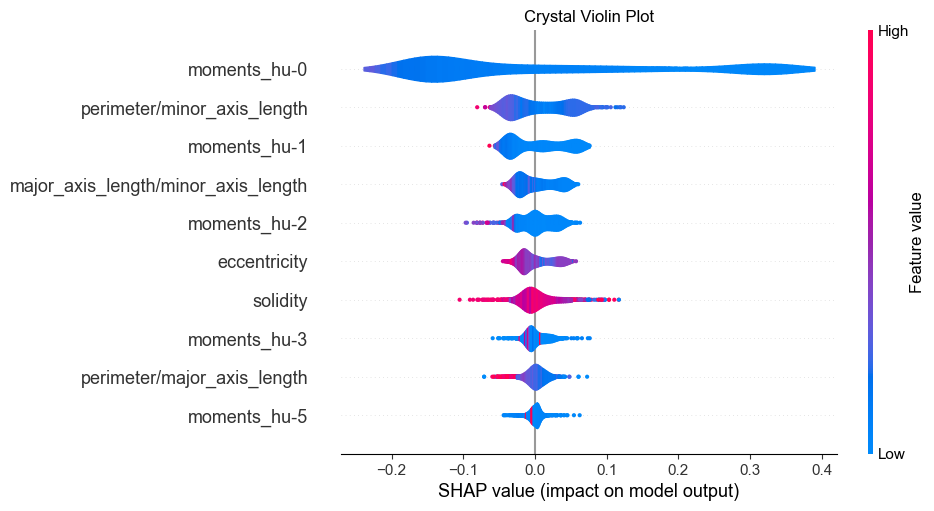

<Figure size 640x480 with 0 Axes>

In [9]:
shap.plots.violin(shap_values[:,:,0],show=False) # Crystal
plt.title("Crystal Violin Plot")
plt.show()
plt.savefig("S1_Shapley_Crystal.png")

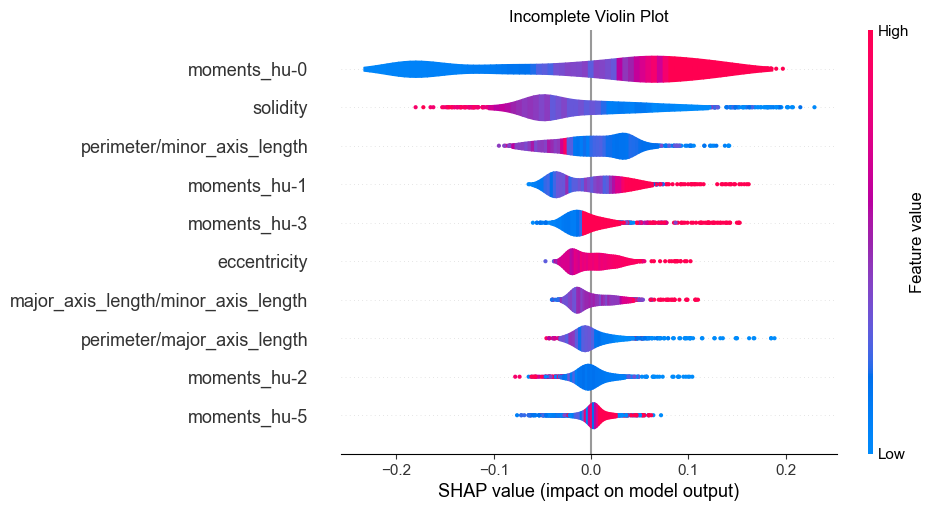

<Figure size 640x480 with 0 Axes>

In [10]:
shap.plots.violin(shap_values[:,:,1],show=False) # Incomplete
plt.title("Incomplete Violin Plot")
plt.show()
plt.savefig("S1_Shapley_Incomplete.png")

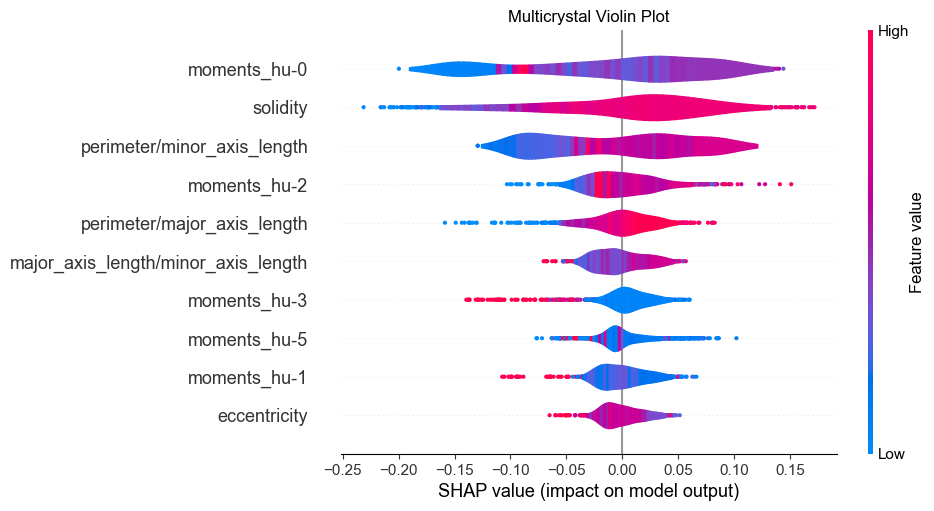

<Figure size 640x480 with 0 Axes>

In [11]:
shap.plots.violin(shap_values[:,:,2],show=False) # Multicrystal
plt.title("Multicrystal Violin Plot")
plt.show()
plt.savefig("S1_Shapley_Multicrystal.png")

In [12]:
# Now check the multiscale models